# Active Inference cadCAD model

This notebook explores active inference agent modeling 
This notebook adds a frontend interface for visualizing the model outputs and playing around with the parameters.
![](opsci_baseline_stock&flow.png)

## Developing Active Inference Agents in cadCAD

An active inference agent consists of the following matrices:
- $A$ -> $P(o|s)$ the generative model's prior beliefs about how hidden states relate to observations
- $B$ -> $𝑃(𝑠_𝑡∣𝑠_{𝑡−1},𝑢_{𝑡−1})$ the generative model's prior beliefs about controllable transitions between hidden states over time
- $C$ -> $P(o)$ the biased generative model's prior preference for particular observations encoded in terms of probabilities
- $D$ -> $P(s)$ the generative model's prior belief over hidden states at the first timestep
- $E$ -> agent's affordances (in this notebook referred to as 'actions')

## cadCAD Standard Notebook Layout

### 0. Dependencies

In [1]:
import pandas as pd
import numpy as np
from random import normalvariate, random
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

from radcad import Model, Simulation, Experiment

from pymdp import utils
from pymdp.maths import softmax

# Additional dependencies

# For analytics
import itertools

# For visualization
import plotly.express as px

# local utils
import utils as u

### 0. Useful functions

In [2]:
actions = ["UP", "DOWN", "LEFT", "RIGHT", "STAY"]

def create_B_matrix():
  B = np.zeros( (len(grid_locations), len(grid_locations), len(actions)) )

  for action_id, action_label in enumerate(actions):

    for curr_state, grid_location in enumerate(grid_locations):

      y, x = grid_location

      if action_label == "UP":
        next_y = y - 1 if y > 0 else y 
        next_x = x
      elif action_label == "DOWN":
        next_y = y + 1 if y < 2 else y 
        next_x = x
      elif action_label == "LEFT":
        next_x = x - 1 if x > 0 else x 
        next_y = y
      elif action_label == "RIGHT":
        next_x = x + 1 if x < 2 else x 
        next_y = y
      elif action_label == "STAY":
        next_x = x
        next_y = y
      new_location = (next_y, next_x)
      next_state = grid_locations.index(new_location)
      B[next_state, curr_state, action_id] = 1.0
  return B

Dimensionality of hidden states: 9
Dimensionality of observations: 9


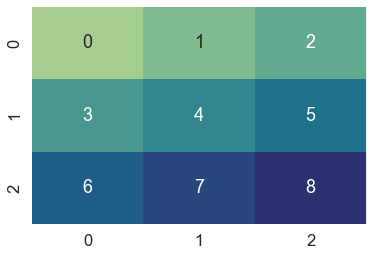

In [3]:
grid_locations = list(itertools.product(range(3), repeat = 2))
n_states = len(grid_locations)
n_observations = len(grid_locations)

print(f'Dimensionality of hidden states: {n_states}')
print(f'Dimensionality of observations: {n_observations}')
u.plot_grid(grid_locations)

In [4]:
grid_locations[0]

(0, 0)

In [5]:
""" Fill out the components of the generative model """

A = np.eye(n_observations, n_states)

B = create_B_matrix()

C = utils.onehot(grid_locations.index( (2, 2) ), n_observations) # make the agent prefer location (2,2) (lower right corner of grid world)

D = utils.onehot(grid_locations.index( (1,2) ), n_states) # start the agent with the prior belief that it starts in location (1,2) 

actions = ["UP", "DOWN", "LEFT", "RIGHT", "STAY"]

The pymdp inference loop has the following steps:
- initialize prior to the D matrix
- get observation index from `grid_locations`
- (q_s) perform inference over hidden states with `infer_states`, passing in the observation index, the A matrix, and the prior
- calculate expected free energy, passing in the A, B, C matrices, the inferences (q_s) from the previous step, and available actions
- compute action posterior (it's the softmax of -G)
- sample the action posterior the get the action
- compute the prior for next state with the dot product of the B matrix (indexed with the chosen action) and the current inference (q_s)

In cadCAD terms:
- possible policy subfunctions (contained in one policy function):
    - `get_observation`
    - `infer_states`
    - `calc_efe`
    - `calc_action_posterior`
    - `sample_action`
    - `calc_next_prior`
    - `update_env_state`
- states:
    - `prior`
    - `env_state`

### 1. State Variables

In [32]:
initial_state = {
    'prior_A': A,
    'prior_B': B,
    'prior_C': C,
    'prior': D,
    'env_state': grid_locations[0],
    'action': '',
    'current_inference': 0
}

In [7]:
grid_locations.index((0,0))

0

### 2. System Parameters

In [33]:
params = {
    'prior_A': A,
    'prior_B': B,
    'prior_C': C,
    'prior': D,
    'env_state': grid_locations,
    'actions': ["UP", "DOWN", "LEFT", "RIGHT", "STAY"]
}

### 3. Policy Functions

- `get_observation`
- `infer_states`
- `calc_efe`
- `calc_action_posterior`
- `sample_action`
- `calc_next_prior`
- `update_env_state`

In [9]:
params['actions'][0]

'UP'

In [34]:
def p_actinf(params, substep, state_history, previous_state):
    # get obs_idx
    obs_idx = grid_locations.index(previous_state['env_state'])

    # infer_states
    qs_current = u.infer_states(obs_idx, previous_state['prior_A'], previous_state['prior'])

    # calc efe
    G = u.calculate_G(previous_state['prior_A'], previous_state['prior_B'], previous_state['prior_C'], qs_current, params['actions'])

    # calc action posterior
    Q_u = softmax(-G)

    # sample action
    chosen_action = utils.sample(Q_u)

    # calc next prior
    prior = previous_state['prior_B'][:,:,chosen_action].dot(qs_current) 

    # update env state
    # action_label = params['actions'][chosen_action]

    (Y, X) = previous_state['env_state']
    Y_new = Y
    X_new = X

    if chosen_action == 0: # UP
          
        Y_new = Y - 1 if Y > 0 else Y
        X_new = X

    elif chosen_action == 1: # DOWN

        Y_new = Y + 1 if Y < 2 else Y
        X_new = X

    elif chosen_action == 2: # LEFT
        Y_new = Y
        X_new = X - 1 if X > 0 else X

    elif chosen_action == 3: # RIGHT
        Y_new = Y
        X_new = X +1 if X < 2 else X

    elif chosen_action == 4: # STAY
        Y_new, X_new = Y, X 
        
    current_state = (Y_new, X_new) # store the new grid location

    return {'update_prior': prior,
            'update_env': current_state,
            'update_action': chosen_action,
            'update_inference': qs_current}

### 4. State Update Functions

In [35]:
def s_prior(params, substep, state_history, previous_state, policy_input):
    updated_prior = policy_input['update_prior']
    return 'prior', updated_prior

def s_env(params, substep, state_history, previous_state, policy_input):
    updated_env_state = policy_input['update_env']
    return 'env_state', updated_env_state

def s_action(params, substep, state_history, previous_state, policy_input):
    return 'action', policy_input['update_action']

def s_qs(params, substep, state_history, previous_state, policy_input):
    return 'current_inference', policy_input['update_inference']

### 5. Partial State Update Blocks

In [36]:
state_update_blocks = [
    {
        'policies': {
            'p_actinf': p_actinf
        },
        'variables': {
            'prior': s_prior,
            'env_state': s_env,
            'action': s_action,
            'current_inference': s_qs
        }
    }
]

### 6. Configuration

In [37]:
model = Model(
    # Model initial state
    initial_state=initial_state,
    # Model Partial State Update Blocks
    state_update_blocks=state_update_blocks,
    # System Parameters
    params=params
)

### 7. Execution

In [41]:
simulation = Simulation(
    model=model,
    timesteps=100,  # Number of timesteps
    runs=1  # Number of Monte Carlo Runs
)

In [45]:
result = simulation.run()

### 8. Analysis

In [46]:
df = pd.DataFrame(result)
df

,prior_A,prior_B,prior_C,prior,env_state,action,current_inference,simulation,subset,run,substep,timestep
0,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]...","[[[1.0, 0.0, 1.0, 0.0, 1.0], [0.0, 0.0, 1.0, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]","(0, 0)",,0,0,0,1,0,0
1,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]...","[[[1.0, 0.0, 1.0, 0.0, 1.0], [0.0, 0.0, 1.0, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.4999999999999999, 4.99999999...","(1, 0)",1,"[0.4999999999999999, 4.9999999999999814e-17, 4...",0,0,1,1,1
2,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]...","[[[1.0, 0.0, 1.0, 0.0, 1.0], [0.0, 0.0, 1.0, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[1.0, 4.999999999999962e-32, 4.999999999999962...","(0, 0)",0,"[1.9999999999999897e-32, 1.9999999999999897e-3...",0,0,1,1,2
3,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]...","[[[1.0, 0.0, 1.0, 0.0, 1.0], [0.0, 0.0, 1.0, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[1.0, 1.9999999999999862e-32, 2.99999999999998...","(0, 0)",0,"[1.0, 9.999999999999931e-33, 9.999999999999931...",0,0,1,1,3
4,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]...","[[[1.0, 0.0, 1.0, 0.0, 1.0], [0.0, 0.0, 1.0, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[1.0, 1.9999999999999862e-32, 1.99999999999998...","(0, 0)",0,"[1.0, 9.999999999999931e-33, 9.999999999999931...",0,0,1,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...
904,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]...","[[[1.0, 0.0, 1.0, 0.0, 1.0], [0.0, 0.0, 1.0, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 9.999999999999931e-33, 1.999999999999986...","(2, 2)",3,"[9.999999999999931e-33, 9.999999999999931e-33,...",0,8,1,1,96
905,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]...","[[[1.0, 0.0, 1.0, 0.0, 1.0], [0.0, 0.0, 1.0, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 9.999999999999931e-33, 9.99999...","(2, 2)",1,"[9.999999999999931e-33, 9.999999999999931e-33,...",0,8,1,1,97
906,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]...","[[[1.0, 0.0, 1.0, 0.0, 1.0], [0.0, 0.0, 1.0, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 9.999999999999931e-33, 9.99999...","(2, 2)",1,"[9.999999999999931e-33, 9.999999999999931e-33,...",0,8,1,1,98
907,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]...","[[[1.0, 0.0, 1.0, 0.0, 1.0], [0.0, 0.0, 1.0, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 9.999999999999931e-33, 1.999999999999986...","(2, 2)",3,"[9.999999999999931e-33, 9.999999999999931e-33,...",0,8,1,1,99


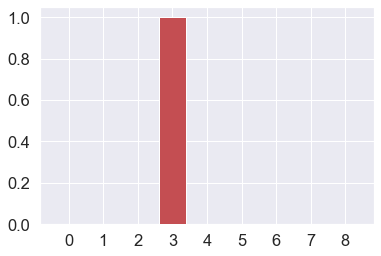

In [49]:
u.plot_beliefs(df['prior'][99])